## loading attention files

In [1]:
from glob import glob

partial_prompt_files = glob('outputs/partial/*.pkl')
full_prompt_files  = glob('outputs/full/*.pkl')

# partial_prompt_files = [p.split('/')[-1] for p in partial_prompt_files]
# full_prompt_files = [p.split('/')[-1] for p in full_prompt_files]

print(len(full_prompt_files))
print(len(partial_prompt_files))


53
67


## getting attention on strategy tokens

In [2]:
from analyze_attention_weights import get_average_attention_over_sequence
import pickle
from transformers import AutoTokenizer
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')

def get_attention_per_strategy(files):
    data = []
    for file in files:
        with open(file, 'rb') as f:
            data.append(pickle.load(f))

    res = {}
    for example in tqdm(data):
        for strategy, (tokens, attentions) in example.items():
            strategy_str = f'"{strategy}"'
            attn = get_average_attention_over_sequence(attentions, tokens, sequence=strategy_str, tokenizer=tokenizer)
            if strategy in res:
                res[strategy].append(attn)
            else:
                res[strategy] = [attn]
    return res


# partial_attns = get_attention_per_strategy(partial_prompt_files)
# full_attns = get_attention_per_strategy(full_prompt_files)

    

In [4]:
import re

def get_attention_per_strategy_and_description(files):
    data = []
    for file in files:
        with open(file, 'rb') as f:
            data.append(pickle.load(f))

    res = {}
    for example in tqdm(data):
        for strategy, (tokens, attentions) in example.items():
            decoded_prompt = tokenizer.decode(tokens, skip_special_tokens=False)
            # print(decoded_prompt)
            match = re.findall(f'You are a helpful and caring friend.+{strategy} strategy\.', decoded_prompt)[0]

            attn = get_average_attention_over_sequence(attentions, tokens, sequence=match, tokenizer=tokenizer)
            if strategy in res:
                res[strategy].append(attn)
            else:
                res[strategy] = [attn]
    return res


partial_attns = get_attention_per_strategy_and_description(partial_prompt_files)
full_attns = get_attention_per_strategy_and_description(full_prompt_files)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 53/53 [00:50<00:00,  1.06it/s]


## visualize results

In [12]:
print({k: len(v) for k,v in partial_attns.items()})
print({k: len(v) for k,v in full_attns.items()})

{'Affirmation': 21, 'Clarification': 29, 'Collaborative Planning': 20, 'Reflective Statements': 26, 'Avoid Judgment and Criticism': 25, 'Emotional Validation': 21, 'Normalize Experiences': 27, 'Offer Hope': 25, 'Promote Self-Care Practices': 14, 'Provide Different Perspectives': 25, 'Reframe Negative Thoughts': 17, 'Suggest Options': 27, 'Chit Chat': 15, 'Share Information': 13, 'Stress Management': 11}
{'Collaborative Planning': 14, 'Reflective Statements': 20, 'Stress Management': 19, 'Emotional Validation': 13, 'Normalize Experiences': 21, 'Provide Different Perspectives': 13, 'Reframe Negative Thoughts': 17, 'Suggest Options': 18, 'Chit Chat': 17, 'Promote Self-Care Practices': 14, 'Share Information': 19, 'Avoid Judgment and Criticism': 15, 'Clarification': 17, 'Offer Hope': 12, 'Affirmation': 14}


In [5]:
import numpy as np
import seaborn as sns
import pandas as pd

partial_attns_avg = {k: np.mean(v) for k,v in partial_attns.items()}
full_attns_avg = {k: np.mean(v) for k,v in full_attns.items()}

strs1 = list(partial_attns_avg.keys())
partial_vals = list(partial_attns_avg.values())
prompt1 = ['partial' for _ in strs1]

strs2 = list(full_attns_avg.keys())
full_vals = list(full_attns_avg.values())
prompt2 = ['full' for _ in strs2]

df = pd.DataFrame({'strategy': strs1+strs2, 'prompt': prompt1+prompt2, 'attention': partial_vals+full_vals})


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


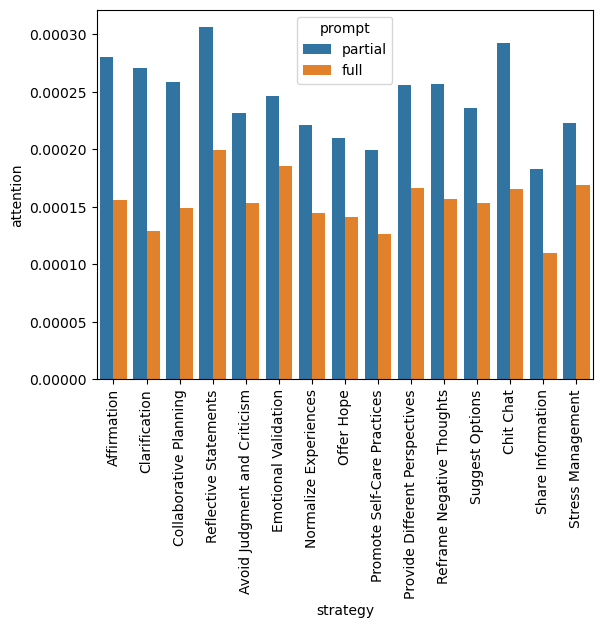

In [6]:
import matplotlib.pyplot as plt

sns.barplot(df, x='strategy', y='attention', hue='prompt')
plt.xticks(rotation=90)
plt.show()